In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

In [2]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    

In [4]:
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

from PIL import Image

directory_benign_train = '../input/skin-cancer-malignant-vs-benign/train/benign'
directory_malignant_train = '../input/skin-cancer-malignant-vs-benign/train/malignant'
directory_benign_test = '../input/skin-cancer-malignant-vs-benign/test/benign'
directory_malignant_test = '../input/skin-cancer-malignant-vs-benign/test/malignant'

## Loading images and converting them to numpy array using their RGB value
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
# np.asarray converts the objects into array/list

# Loading train images
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]

# Loading test images
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]


In [5]:
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign
There are 0 directories and 300 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train
There are 0 directories and 1440 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign
There are 0 directories and 1197 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/tes

In [6]:
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

In [7]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [8]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [9]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))


In [10]:
# View first 5 samples in the training set
train_df.tail(9)

image_path      label  \
2628  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2629  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2630  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2631  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant   
2632  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant   
2633  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2634  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2635  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   
2636  /kaggle/input/skin-cancer-malignant-vs-benign/...     benign   

      label_encoded  
2628              1  
2629              1  
2630              1  
2631              0  
2632              0  
2633              1  
2634              1  
2635              1  
2636              1

In [11]:
X_benign_train = np.array(img_benign_train)
X_malignant_train = np.array(img_malignant_train)

X_benign_test = np.array(img_benign_test)
X_malignant_test = np.array(img_malignant_test)

In [12]:
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

y_malignant_train

array([1., 1., 1., ..., 1., 1., 1.])

In [13]:
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

print("Shape of X_train: ", X_train.shape) # one image constitutes to (224, 224, 3) and we have 2637 total images in training set
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


In [14]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

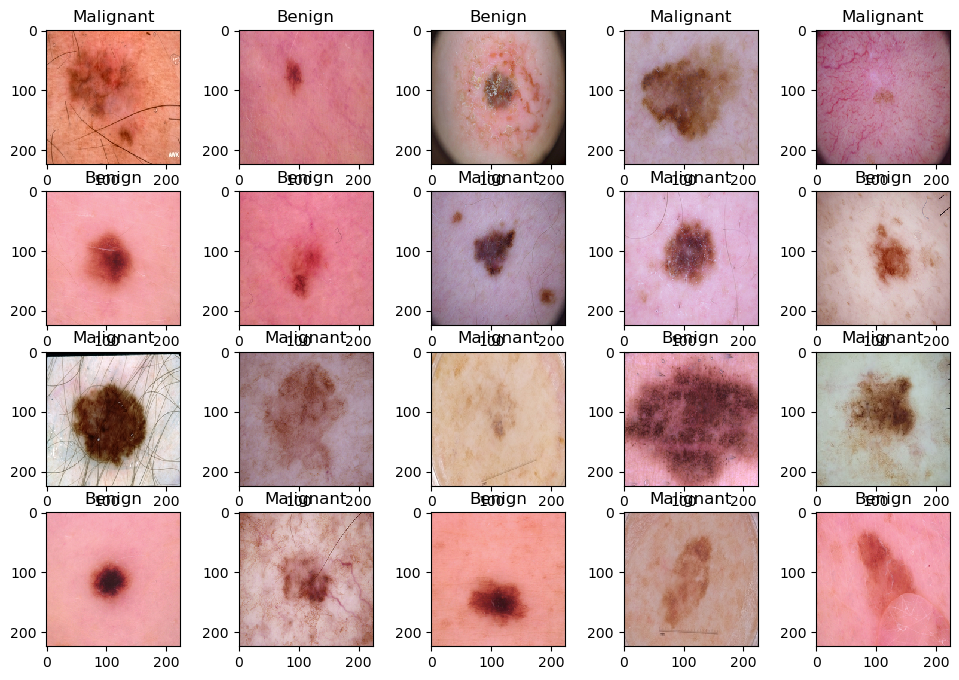

In [15]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [16]:
# # Select random sample from train_df
# idx = random.sample(train_df.index.to_list(), 1)[0]

# # Load the random sample and label
# sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# # View the random sample
# fig = plt.figure(figsize=(3,3))
# view_sample(sample_image, sample_label)

In [17]:
import keras
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [18]:
X_train = X_train/255
X_test = X_test/255

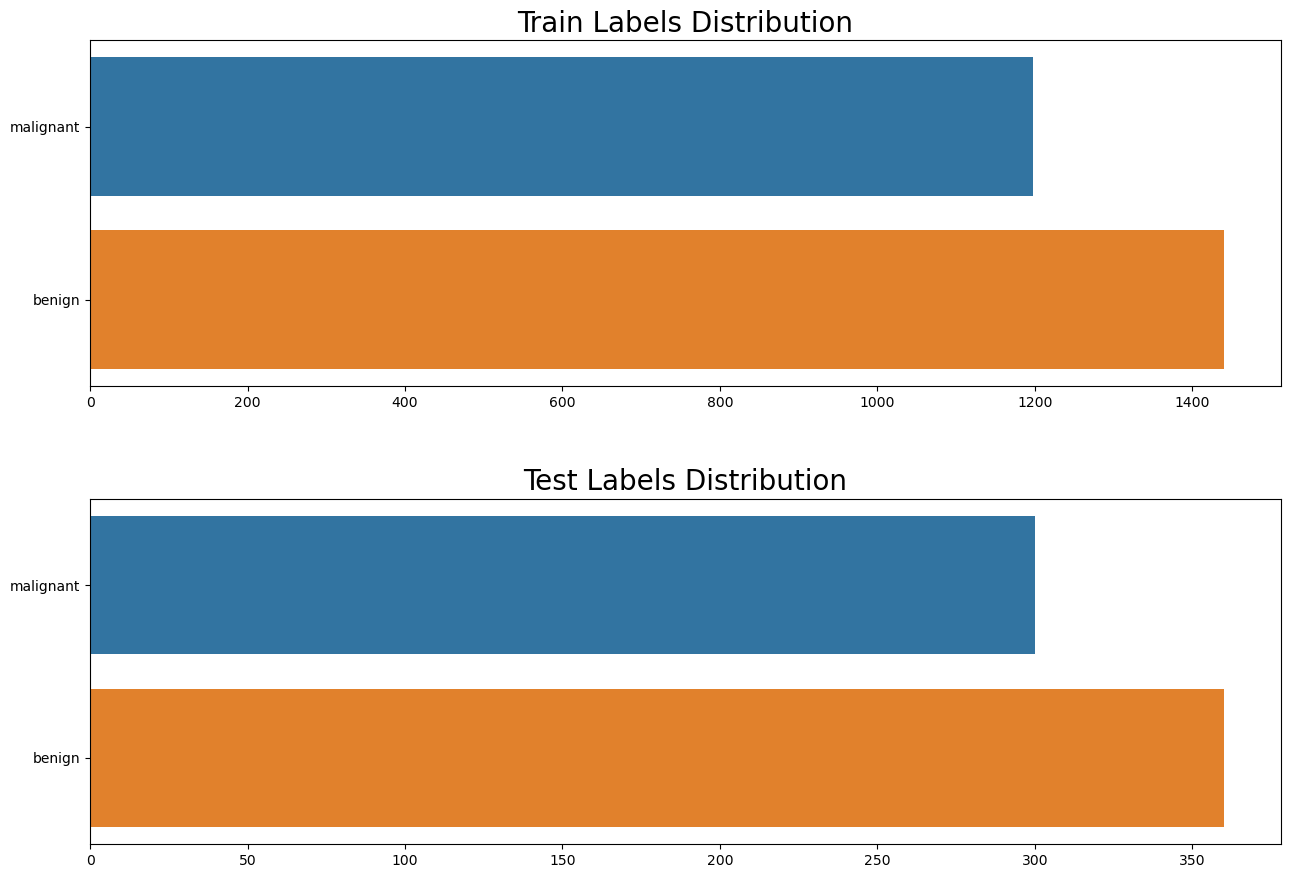

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.index),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.index),
            orient="h",
            ax=ax2)

plt.show()


In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

def build_cnn_model(input_shape = (224, 224, 3), num_classes=2):
    
    model = Sequential()
    
    # adding 64 filters, each filter has a size of 3*3
    # padding is of 2 types: SAME and VALID (SAME means doing the padding around the image, VALID means no padding)
    # kernel initilizer is for intializing the weights of the network --> the default one is glorot_uniform so don't need to mention parameter
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2,2)))
    # 25% of the nodes will be dropped out
    model.add(Dropout(0.25)) 
    
    
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())
    
    # normal initializer draws samples from a truncated normal distribution centered at 0 and SD = sqrt(2/number of input units)
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.summary()
    
    
    ## OPTIMIZERS are the functions to adjust the weights and minimize the loss
    # Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. 
    # Adam is relatively easy to configure where the default configuration parameters do well on most problems
    # lr is the alpha rate i.e. learning rate
    optimizer= Adam(lr=0.001) 
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    
    return model   

In [21]:

model_cnn = build_cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

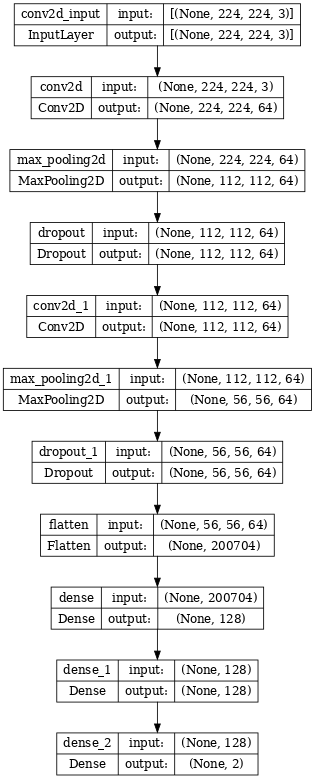

In [23]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [24]:
from keras.callbacks import ReduceLROnPlateau

# Learning rate annealer is used to reduce the learning rate by some percentage after certain number of training iterations/epochs
learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc',
                                          patience=5,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr = 1e-7)

# epochs is the number of iterations
# batch_size is the number of images in one epoch
# verbose = 1 shows us the animation of the epoch using progres_bar
history = model_cnn.fit(X_train, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size = 64, 
                    verbose=1,
                    callbacks=[learning_rate_annealer])


# list all data in history
print(history.history.keys())

Epoch 1/10
33/33 [==============================] - 207s 6s/step - loss: 1.0480 - accuracy: 0.5486 - val_loss: 0.6924 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - 205s 6s/step - loss: 0.6615 - accuracy: 0.6183 - val_loss: 0.6547 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - 205s 6s/step - loss: 0.5602 - accuracy: 0.7359 - val_loss: 0.5448 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - 205s 6s/step - loss: 0.4585 - accuracy: 0.7672 - val_loss: 0.5010 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 5/10
33/33 [==============================] - 204s 6s/step - loss: 0.4085 - accuracy: 0.7942 - val_loss: 0.4899 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 6/10
33/33 [==============================] - 204s 6s/step - loss: 0.4599 - accuracy: 0.7696 - val_loss: 0.4896 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 7/10
33/33 [==============================] - 203s 6s/step - loss: 0.3

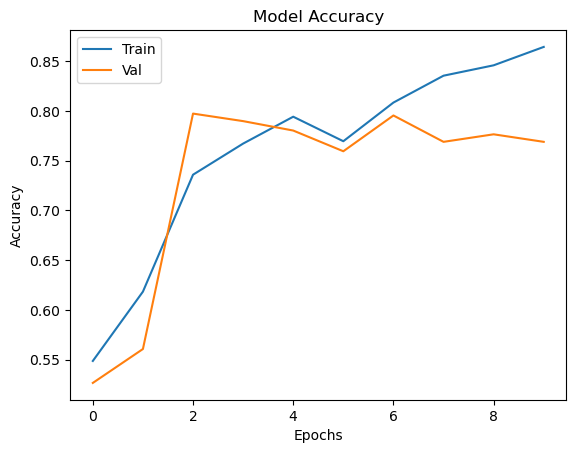

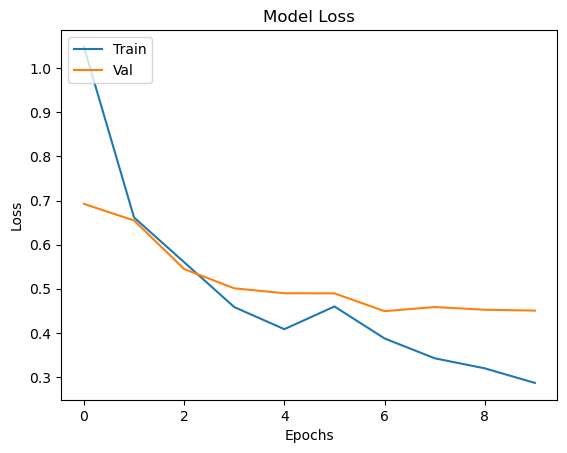

In [25]:
# 1. Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 2. Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score

# Testing model on test data to evaluate
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

21/21 [==============================] - 15s 718ms/step
0.8106060606060606


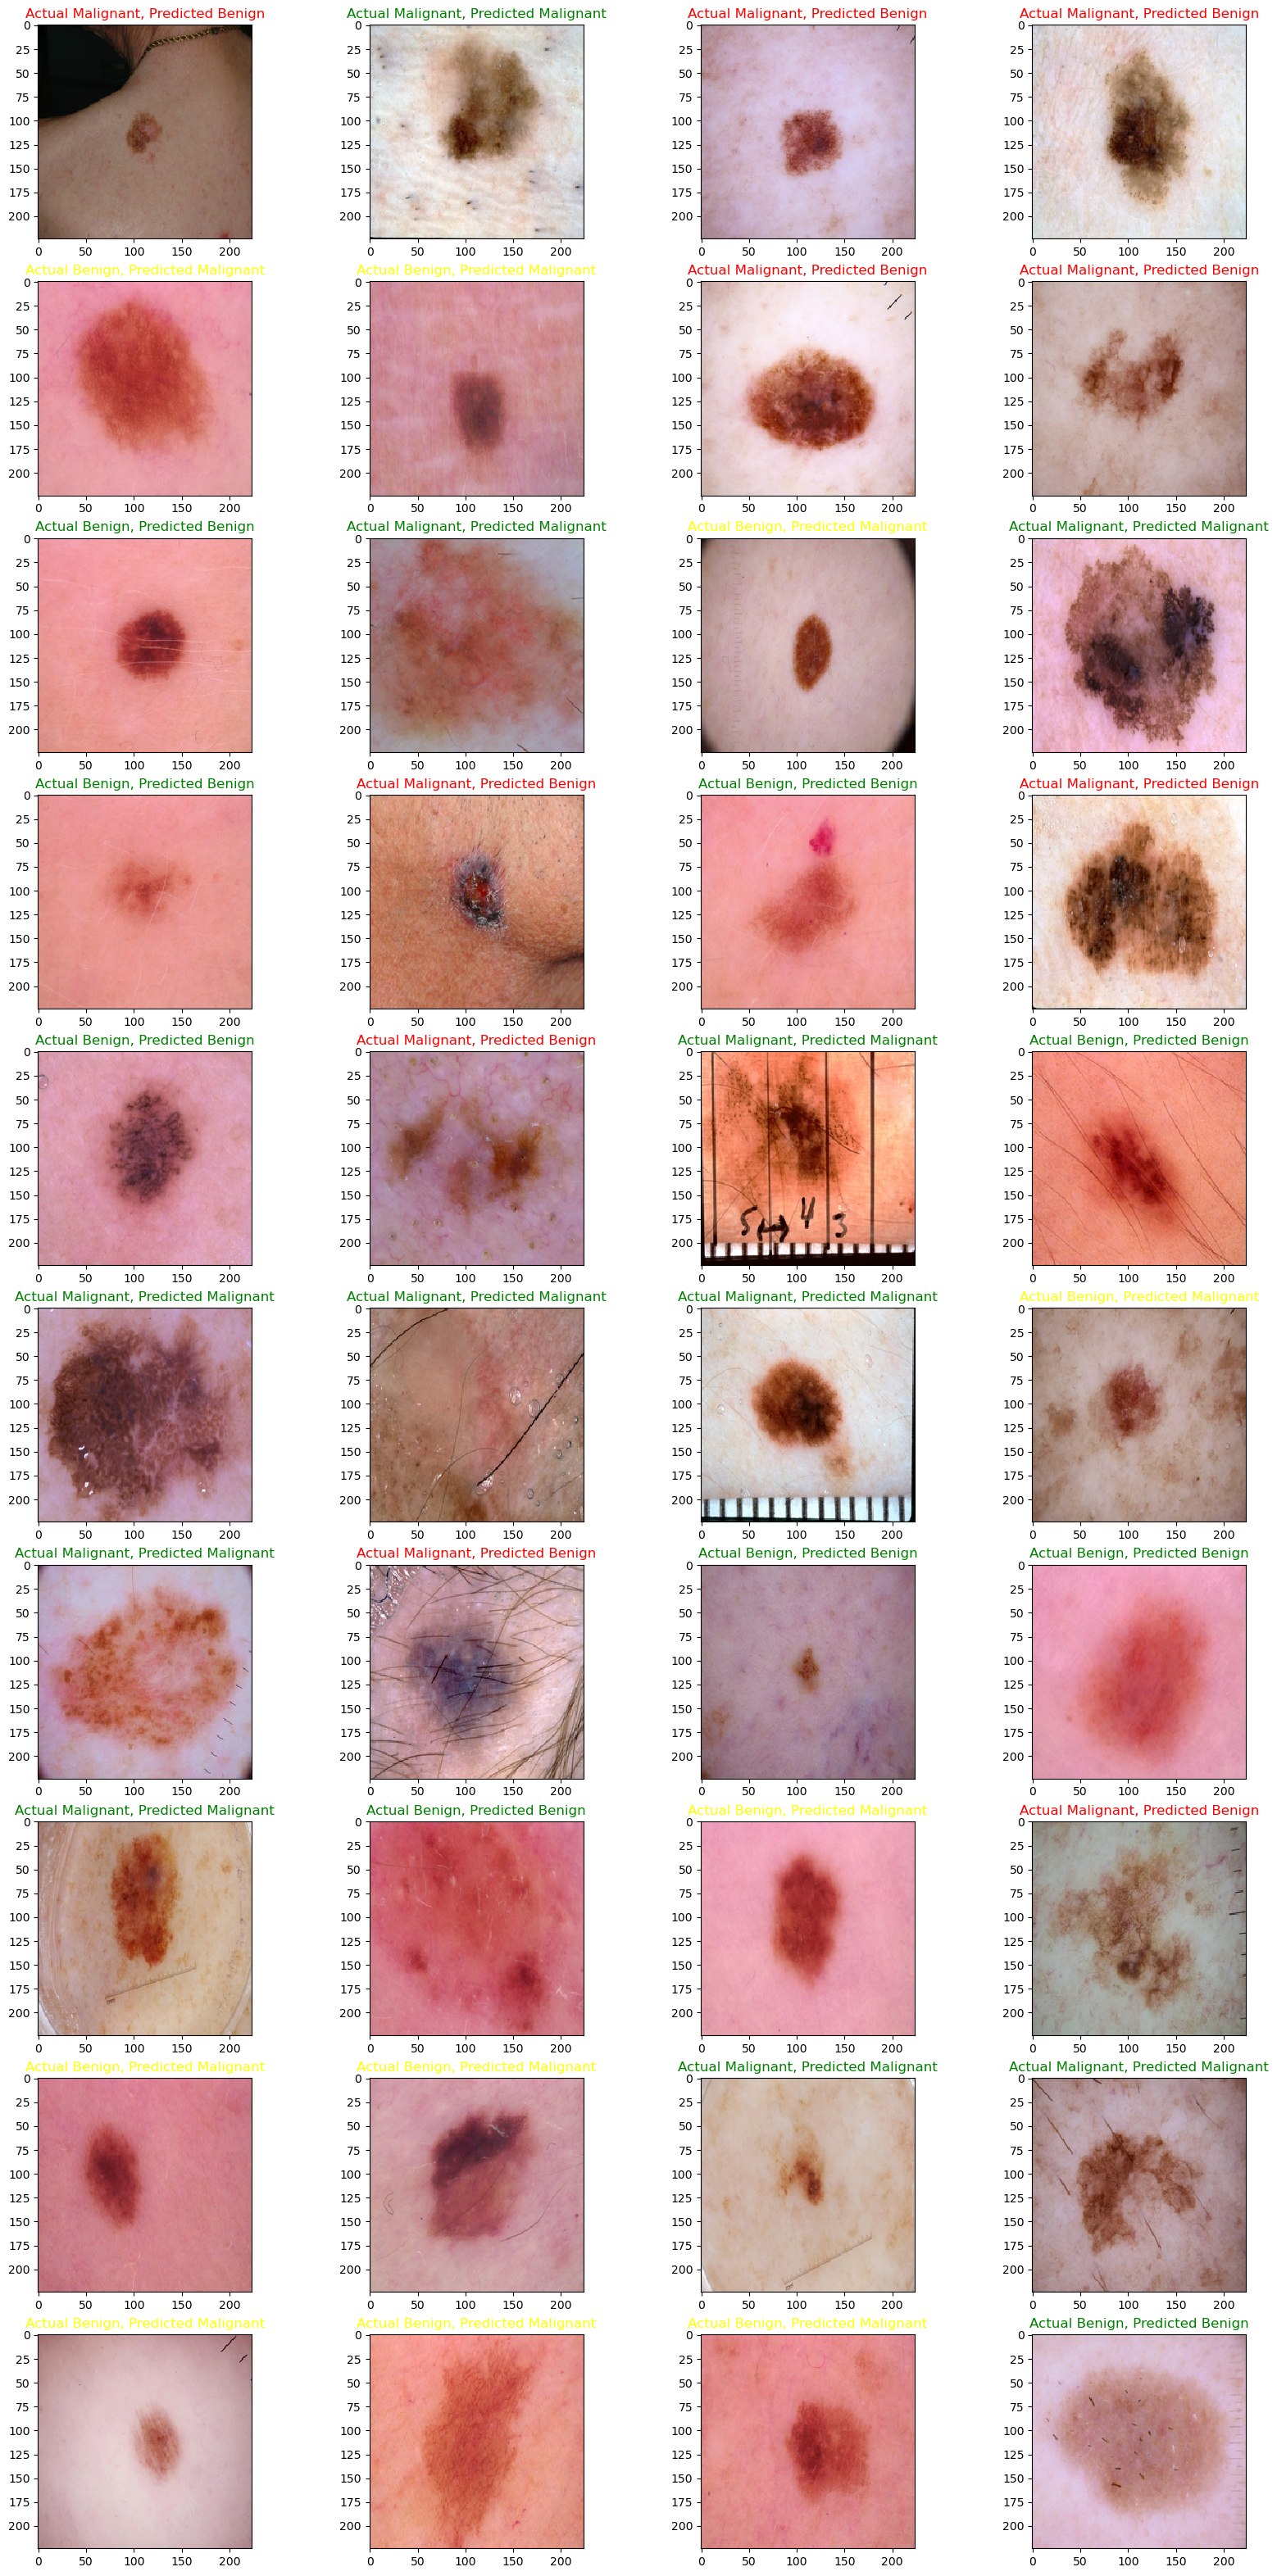

In [27]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# shuffling data
s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]
y_pred = y_pred[s2]

# plotting
fig = plt.figure(figsize=(20,40))
columns = 4
rows = 10

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_test[i] == 1:       
        if y_pred[i] == 1:
            ax.set_title('Actual Malignant, Predicted Malignant', color='green')
        else:
            ax.set_title('Actual Malignant, Predicted Benign', color='red')
    
    else:
        if y_pred[i] == 0:
            ax.set_title('Actual Benign, Predicted Benign', color='green')
        else:
            ax.set_title('Actual Benign, Predicted Malignant', color='yellow')

        
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()